## (1) Datenerhebung mittels Web Scraping UND Web API

Hier wird geprüft, ob der Ordner Projektarbeit_ADS_Gruppe1 im Pfad /content bereits existiert. Wenn er nicht vorhanden ist, wird der Ordner erstellt und eine Bestätigung ausgegeben. Andernfalls wird eine Nachricht ausgegeben, die bestätigt, dass der Ordner bereits vorhanden ist.

In [1]:
import os

input_path = "./data/"
output_path = "./output/"


if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Ordner {output_path} wurde erfolgreich erstellt.")
else:
    print(f"Ordner {output_path} existiert bereits.")

Ordner ./output/ existiert bereits.


In [2]:
#@title 1.1 Web Scraping

from bs4 import BeautifulSoup
import requests
import pandas as pd
import os

# Get current working directory
print(os.getcwd())

# Add url of the page you want to scrape to urlString
urlString='https://mlsplayers.org/resources/salary-guide'

def salaryExtractor(urlString):
    # Make a request to the URL and get the content of the response
    getH = requests.get(urlString)
    h = getH.content
    
    # Create a BeautifulSoup object with the content
    soup = BeautifulSoup(h, 'html.parser')
    
    # Find the table with id 'salary-report'
    salaryTable = soup.select('table#salary-report')
    
    # Convert the HTML table to a DataFrame using pandas
    df = pd.read_html(str(salaryTable))[0]
    
    # Merge the 'First Name' and 'Last Name' columns into a single 'Name' column
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    
    # Drop the 'First Name' and 'Last Name' columns
    df = df.drop(columns=['First Name', 'Last Name'])
    
    # Save the DataFrame to a CSV file
    #timestr = time.strftime("%Y%m%d") # Get current time
    df.to_csv(output_path + '01_salaries.csv', index=False, encoding='utf-8')
    
    #print(df.head(45))
    print('Data saved to 01_salaries.csv')

salaryExtractor(urlString)


/home/jovyan/work
Data saved to 01_salaries.csv


In [3]:
# Get salary sources from past years

# Libraries and settings
#!pip install xlwt

import requests
import xlwt
from bs4 import BeautifulSoup
import pandas as pd
import os
import time

# Get current working directory
print(os.getcwd())

# Add url of the page you want to scrape to urlString
urlString='https://mlsplayers.org/resources/salary-guide'

## Function to extract years and store them in the list
def yearExtractor(urlString):
    getH=requests.get(urlString) # Make a request to a web page, and returns response object:
    
    h=getH.content #  response.content returns the content of the response, in bytes
    #print(h)
    
    soup=BeautifulSoup(h,'html.parser') # pulling data out of HTML and XML files
    #-> gehe durch HTML-Element H mit Parser aus Library html.parser
    #print(soup)

    # find all unordered Lists
    lists = soup.find_all('ul')
    #print(lists)

    #Get desired list V2
    token = 'Download Previous Salary Guides'

    unorderedList = soup.find_all(string=token)[0].findNext('ul').find_all('li')
    #print(unorderedList)
    
    # Defining of the dataframe
    #df = pd.DataFrame(columns=['Year', 'URL'])
    dfs = []
    
    # Collecting Ddata
    for li in unorderedList:
        Year = li.select_one('[class="button"]').get_text()
        URL = li.select_one('[class="button"]')['href']
        #print(Year)
        #print(URL)

        df = pd.DataFrame({'Year': [Year], 'URL': [URL]})
        dfs.append(df)
        #df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
    #print(df)

    # Combine all DataFrames
    df_combined = pd.concat(dfs, ignore_index=True)
    
    #Export DF
    timestr = time.strftime("%Y%m%d") # Get current time
    #df.to_csv(timestr + '_salarySources.csv', index=False, encoding='utf-8')
    df_combined.to_csv(output_path + '00_salarySources.csv', index=False, encoding='utf-8')
    

yearExtractor(urlString)

/home/jovyan/work


### 1.2 Web API

Leistungsdaten der Spieler, Tore, Assist, etc. in CSV-Datei




In [4]:
#@title Libraries and settings
# Libraries
import os
import fnmatch
import locale
locale.setlocale(locale.LC_ALL,"")

import requests
import json
import urllib.request

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /home/jovyan/work


In [6]:
#@title Get Data
import json
import csv

# Authentication endpoint
def authenticate(username, password):
    url = "https://mlssoccerapi.com/v1/login"
    payload = json.dumps({
        "username": username,
        "password": password
    })
    headers = {'Content-Type': 'application/json'}
    response = requests.request("POST", url, headers=headers, data=payload)
    return response

# Players endpoint
def get_players(token, limit=3500):
    url = f"https://mlssoccerapi.com/players?limit={limit}"
    payload = {}
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {token}'
    }
    response = requests.request("GET", url, headers=headers, data=payload)
    return response.json()

if __name__ == "__main__":
    username = "oliverob"  # Fill in your username
    password = "SAbNZptpelXT0UMIoPXnK3Cnqz"  # Fill in your password

    auth_response = authenticate(username, password)

    if auth_response.status_code == 200:
        auth_data = json.loads(auth_response.text)
        access_token = auth_data.get("Document")

        # List of limit values to iterate through
        limits = [500, 1000, 1500, 2000, 2500, 3000, 3500]

        header_written = False

        for limit in limits:
            players_data = get_players(access_token, limit=limit)

            if not header_written:
                # Initialize the CSV file
                with open(output_path + "02_players.csv", "w", newline="") as csvfile:
                    fieldnames = list(players_data["Document"][0].keys()) + ["limit"]
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    writer.writeheader()
                    header_written = True

            # Append data to the CSV file
            with open(output_path + "02_players.csv", "a", newline="") as csvfile:
                fieldnames = list(players_data["Document"][0].keys()) + ["limit"]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                for player in players_data["Document"]:
                    if player.get("league") == "Major League Soccer":
                        # exclude the player_image, country_image, league_image field
                        player.pop("player_image", None)
                        player.pop("country_image", None)
                        player.pop("league_image", None)
                        player["limit"] = limit
                        writer.writerow(player)
                        #print(player)

    else:
        print("Authentication failed")


KeyboardInterrupt: 

CSV-Datei "players.csv" in das Zielverzeichnis "/content/Projektarbeit_ADS_Gruppe1" kopieren ( sicherstellen, dass Zielverzeichnis erstellt)

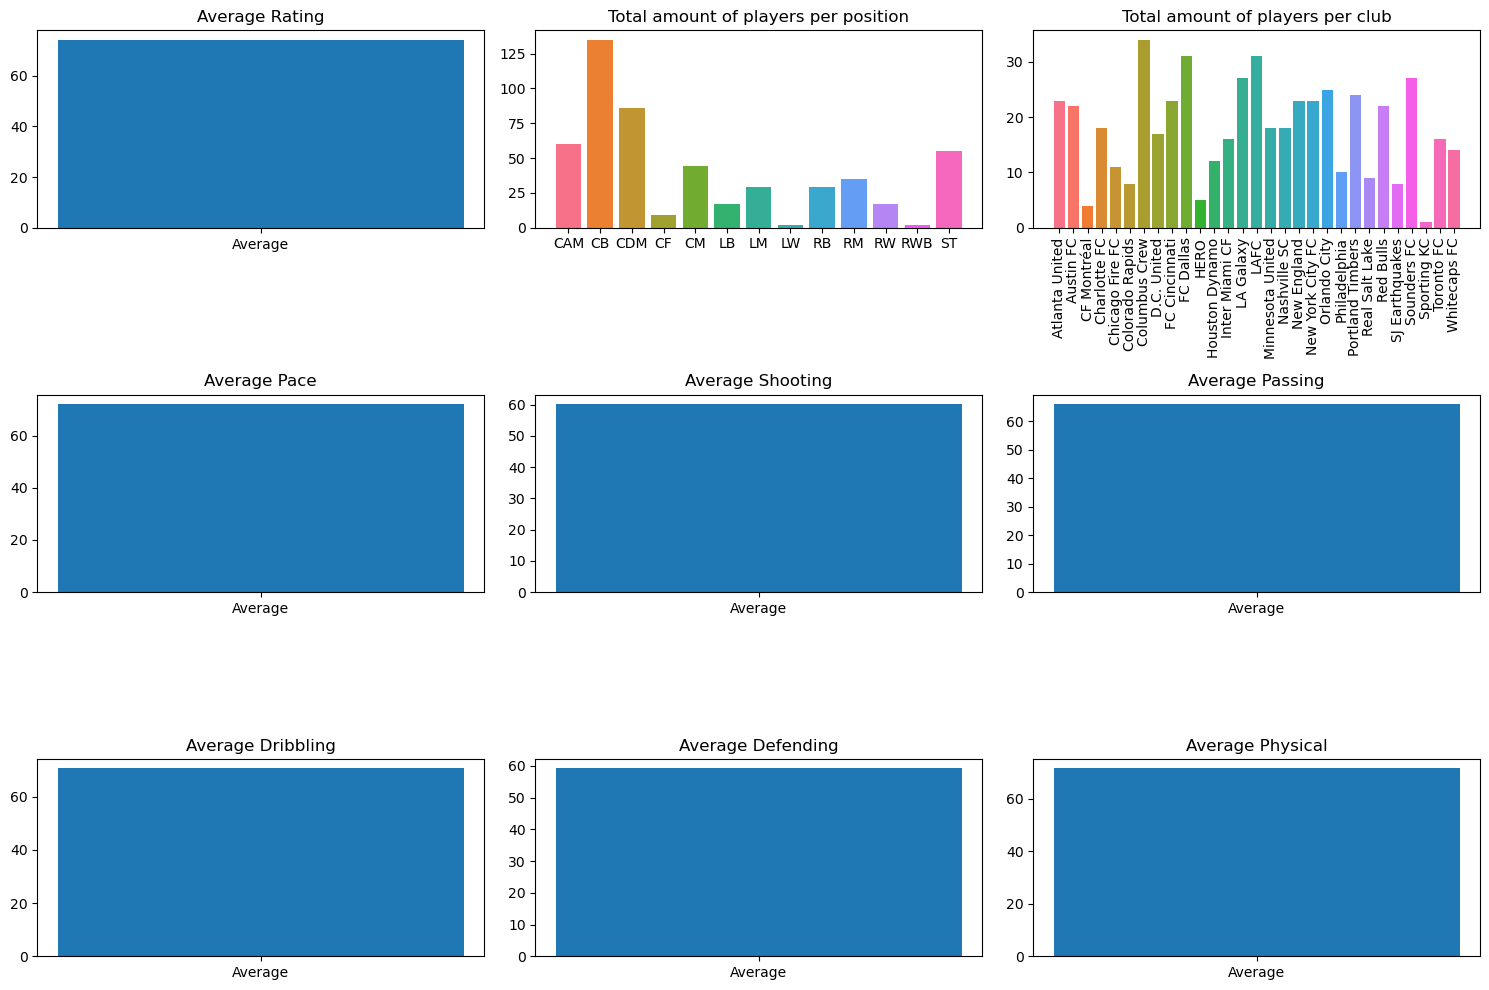

In [6]:
#@title Plot Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(output_path + "02_players.csv")

# set figure size
fig = plt.figure(figsize=(15, 10))

# create color palette
positions = df["position"].unique()
clubs = df["club"].unique()
palette_pos = sns.color_palette("husl", len(positions))
palette_club = sns.color_palette("husl", len(clubs))

# Average rating
plt.subplot(3, 3, 1)
plt.bar(["Average"], [df["rating"].mean()])
plt.title("Average Rating")

# Total amount of players per position
ax1 = plt.subplot(3, 3, 2)
df_position = df.groupby("position").count()["player_name"]
ax1.bar(df_position.index, df_position.values, color=palette_pos)
ax1.set_title("Total amount of players per position")

# Total amount of players per club
ax2 = plt.subplot(3, 3, 3)
df_club = df.groupby("club").count()["player_name"]
ax2.bar(df_club.index, df_club.values, color=palette_club)
ax2.set_xticklabels(df_club.index, rotation=90)
ax2.set_title("Total amount of players per club")

# Average pace
ax3 = plt.subplot(3, 3, 4)
ax3.bar(["Average"], [df["pace"].mean()])
ax3.set_title("Average Pace")

# Average shooting
ax4 = plt.subplot(3, 3, 5)
ax4.bar(["Average"], [df["shooting"].mean()])
ax4.set_title("Average Shooting")

# Average passing
ax5 = plt.subplot(3, 3, 6)
ax5.bar(["Average"], [df["passing"].mean()])
ax5.set_title("Average Passing")

# Average dribbling
ax6 = plt.subplot(3, 3, 7)
ax6.bar(["Average"], [df["dribbling"].mean()])
ax6.set_title("Average Dribbling")

# Average defending
ax7 = plt.subplot(3, 3, 8)
ax7.bar(["Average"], [df["defending"].mean()])
ax7.set_title("Average Defending")

# Average physical
ax8 = plt.subplot(3, 3, 9)
ax8.bar(["Average"], [df["physical"].mean()])
ax8.set_title("Average Physical")

# adjust layout
fig.tight_layout()
plt.show()


## (2) Datenaufbereitung (z.B. Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten, ...)

In [7]:
#Spalten umbenennen, für Merge

# Read the CSV file
df = pd.read_csv(output_path + '01_salaries.csv')

# Create a dictionary mapping old column names to new column names
column_rename_mapping = {
    'Club': 'club',
    'Position(s)': 'position',
    'Name': 'player_name'
}

# Rename the columns using the rename() function
df.rename(columns=column_rename_mapping, inplace=True)

# Save the modified dataframe back to CSV
df.to_csv(output_path + '01_salaries.csv', index=False)

In [23]:
#@title 2.1 Merge/Zusammenführung 
import pandas as pd

def merge_csv_files(salaries_file, players_file, output_file):
    # Read the CSV files into DataFrames
    df_salaries = pd.read_csv(salaries_file)
    df_players = pd.read_csv(players_file)
    
    # Drop the 'position' column from the second DataFrame
    df_salaries.drop('position', axis=1, inplace=True)

    # Merge the DataFrames on a common key (assuming 'Name' column in both files)
    #df_merged = pd.merge(df_salaries, df_players, left_on='player_name', right_on='player_name', how='inner')
    df_merged = pd.merge(df_salaries, df_players, on=['player_name', 'club'], how='inner')

    # Save the merged DataFrame to a new CSV file
    df_merged.to_csv(output_file, index=False, encoding='utf-8')

    # Return the merged DataFrame
    return df_merged

if __name__ == "__main__":
    # Call the function to merge the CSV files and get the merged DataFrame
    merged_df = merge_csv_files(output_path + '01_salaries.csv', output_path + '02_players.csv', output_path + '03_merged_data.csv')

    # Display the first 5 entries
    print(merged_df.head(5))


             club  player_name    Base Salary Guaranteed Compensation   
0  Atlanta United  Luiz Araujo  $3,600,000.00           $4,480,333.00  \
1  Atlanta United  Luiz Araujo  $3,600,000.00           $4,480,333.00   
2  Atlanta United  Luiz Araujo  $3,600,000.00           $4,480,333.00   
3  Atlanta United  Luiz Araujo  $3,600,000.00           $4,480,333.00   
4  Atlanta United  Luiz Araujo  $3,600,000.00           $4,480,333.00   

                                     id  rating  player_image  country_image   
0  1463c6a6-f725-11ed-8195-acde48001122      78           NaN            NaN  \
1  1463c6a6-f725-11ed-8195-acde48001122      78           NaN            NaN   
2  1463c6a6-f725-11ed-8195-acde48001122      78           NaN            NaN   
3  1463c6a6-f725-11ed-8195-acde48001122      78           NaN            NaN   
4  1463c6a6-f725-11ed-8195-acde48001122      78           NaN            NaN   

   league_image position               league  pace  shooting  passing   
0     

### 2.2 Data Cleansing

Removal of empty entries within the column "Name", drop of other not needed columns (id, player_name, player_image, country_image, league_image and league) as well as removal of duplicates.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def remove_missing_name_rows(df, column_name):
    df = df[df[column_name].notna()]
    return df

def remove_duplicates(df, column_name):
    df = df.drop_duplicates(subset=column_name)
    return df

def drop_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop)
    return df

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file(output_path + '03_merged_data.csv')

    # Remove rows with missing values in the 'Name' column
    data_df = remove_missing_name_rows(data_df, 'player_name')

    # Remove duplicate rows based on the 'Name' column
    data_df = remove_duplicates(data_df, 'player_name')

    # Drop the specified columns
    columns_to_drop = ['id', 'player_image', 'country_image', 'league_image', 'league', 'limit']
    data_df = drop_columns(data_df, columns_to_drop)

    # Convert the 'Guaranteed Compensation' column to float
    data_df = convert_currency_to_float(data_df, 'Guaranteed Compensation')

    # Save the cleaned data to a new CSV file
    data_df.to_csv(output_path + '04_cleaned_data.csv', index=False)

    # Display the first 5 entries after processing
    print(data_df.head(5))


              club       player_name    Base Salary  Guaranteed Compensation   
0   Atlanta United       Luiz Araujo  $3,600,000.00                4480333.0  \
6   Atlanta United       Alan Franco    $540,000.00                 667500.0   
7   Atlanta United    Josef Martinez  $3,750,000.00                4141667.0   
13  Atlanta United  Marcelino Moreno    $460,000.00                 568333.0   
20  Atlanta United    Miles Robinson    $700,000.00                 737500.0   

    rating position  pace  shooting  passing  dribbling  defending  physical  
0       78       RM    88        69       72         83         39        57  
6       72       CB    59        34       56         66         71        78  
7       78       ST    85        79       60         77         25        66  
13      85       CM    84        82       85         88         72        74  
20      73       CB    83        35       54         67         72        78  


In [25]:
import pandas as pd

# Read the CSV file
data = pd.read_csv(output_path + "04_cleaned_data.csv")

# Display data types before conversion
print("Data types before conversion:")
print(data[['Base Salary', 'Guaranteed Compensation', 'player_name', 'rating', 'position', 'club', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical']].dtypes)

# Clean data
data['player_name'] = data['player_name'].astype(str)
data['position'] = data['position'].astype(str)
data['club'] = data['club'].astype(str)

# Remove dollar signs, commas, and decimal places
data['Base Salary'] = data['Base Salary'].astype(str).str.replace('[\$,]', '', regex=True).astype(float).astype(int)
data['Guaranteed Compensation'] = data['Guaranteed Compensation'].astype(str).str.replace('[\$,]', '', regex=True).astype(float).astype(int)

# Display data types after conversion
print("\nData types after conversion:")
print(data[['Base Salary', 'Guaranteed Compensation', 'player_name', 'rating', 'position', 'club', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical']].dtypes)

# Save the cleaned data to a new CSV file
data.to_csv(output_path + "05_cleaned_data_2.0.csv", index=False)


Data types before conversion:
Base Salary                 object
Guaranteed Compensation    float64
player_name                 object
rating                       int64
position                    object
club                        object
pace                         int64
shooting                     int64
passing                      int64
dribbling                    int64
defending                    int64
physical                     int64
dtype: object

Data types after conversion:
Base Salary                 int64
Guaranteed Compensation     int64
player_name                object
rating                      int64
position                   object
club                       object
pace                        int64
shooting                    int64
passing                     int64
dribbling                   int64
defending                   int64
physical                    int64
dtype: object


##(3) Umfangreiche Explorative Datenanalyse (EDA)

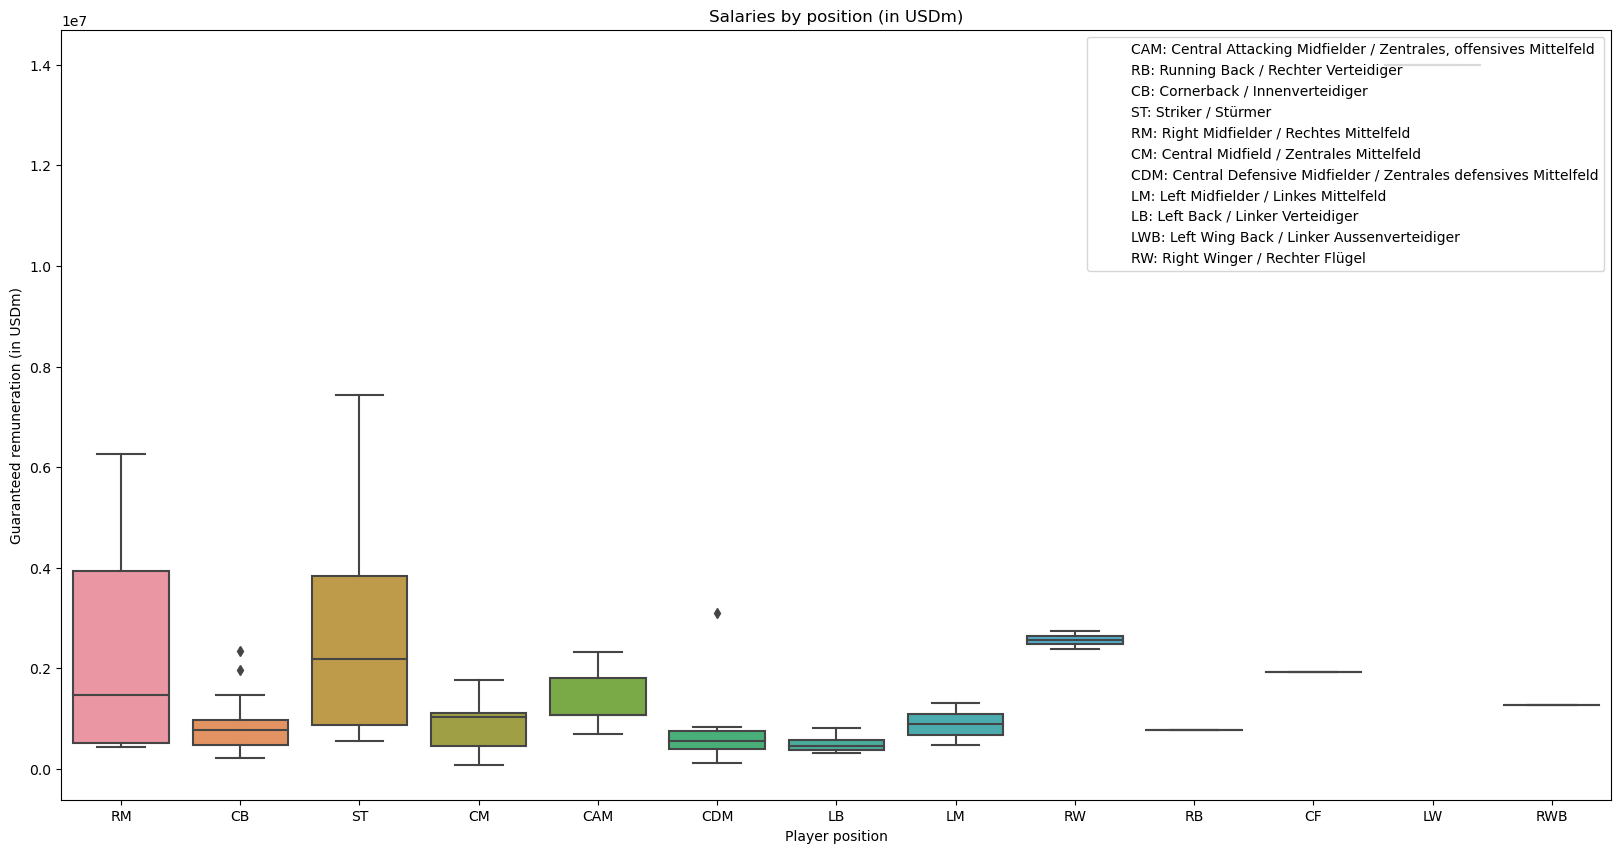

In [26]:
#@title 3.1 Visualisierung der Gehälter nach Position
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')

    plt.figure(figsize=(20, 10))
    sns.boxplot(x='position', y='Guaranteed Compensation', data=data_df)
    plt.title('Salaries by position (in USDm)')
    plt.ylabel('Guaranteed remuneration (in USDm)')
    plt.xlabel('Player position')

    # Legende hinzufügen
    cam_patch = mpatches.Patch(color='none', label='CAM: Central Attacking Midfielder / Zentrales, offensives Mittelfeld')
    rb_patch = mpatches.Patch(color='none', label='RB: Running Back / Rechter Verteidiger')
    cb_patch = mpatches.Patch(color='none', label='CB: Cornerback / Innenverteidiger')
    st_patch = mpatches.Patch(color='none', label='ST: Striker / Stürmer')
    rm_patch = mpatches.Patch(color='none', label='RM: Right Midfielder / Rechtes Mittelfeld')
    cm_patch = mpatches.Patch(color='none', label='CM: Central Midfield / Zentrales Mittelfeld')
    cdm_patch = mpatches.Patch(color='none', label='CDM: Central Defensive Midfielder / Zentrales defensives Mittelfeld')
    lm_patch = mpatches.Patch(color='none', label='LM: Left Midfielder / Linkes Mittelfeld')
    lb_patch = mpatches.Patch(color='none', label='LB: Left Back / Linker Verteidiger')
    lwb_patch = mpatches.Patch(color='none', label='LWB: Left Wing Back / Linker Aussenverteidiger')
    rw_patch = mpatches.Patch(color='none', label='RW: Right Winger / Rechter Flügel')

    plt.legend(handles=[cam_patch, rb_patch, cb_patch, st_patch, rm_patch, cm_patch, cdm_patch, lm_patch, lb_patch, lwb_patch, rw_patch], loc='upper right')

    plt.show()


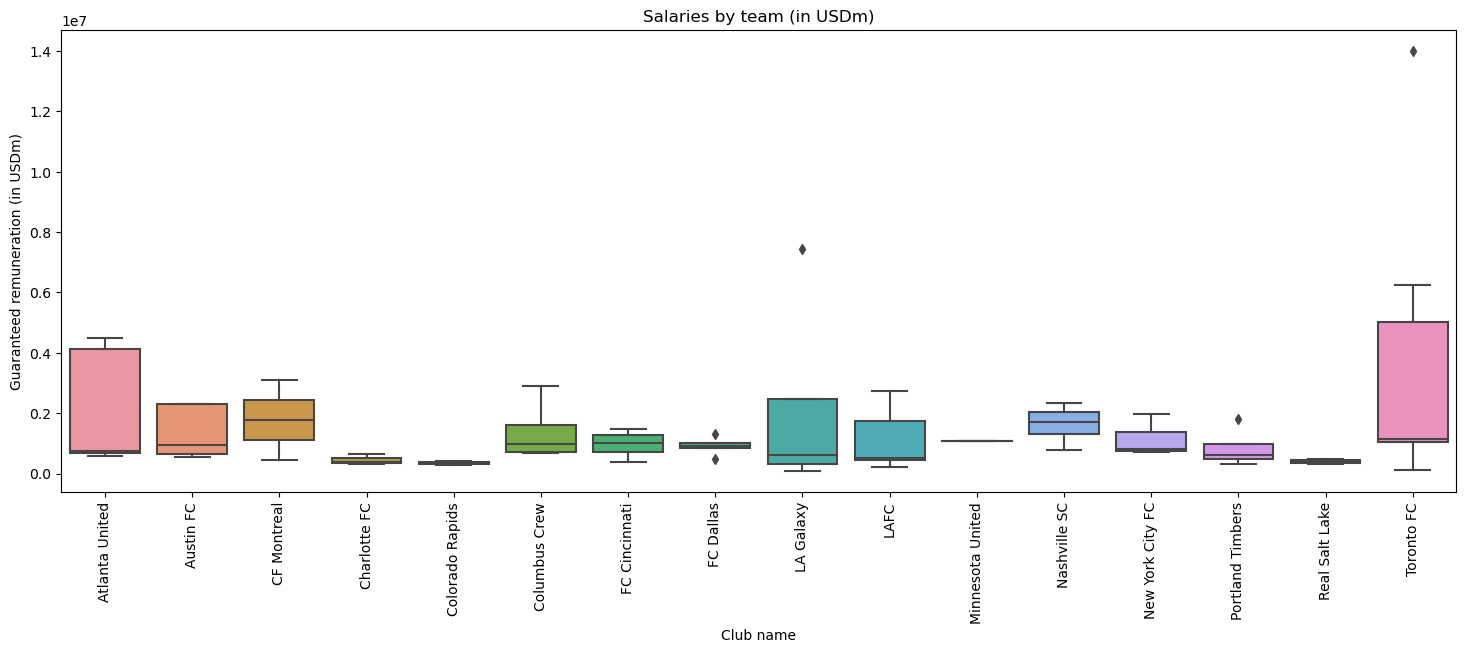

In [27]:
#@title 3.2 Visualisierung der Gehälter nach Club resp. Team
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')
    
    plt.figure(figsize=(18, 6))
    sns.boxplot(x='club', y='Guaranteed Compensation', data=data_df)
    plt.title('Salaries by team (in USDm)')
    plt.ylabel('Guaranteed remuneration (in USDm)')
    plt.xlabel('Club name')
    plt.xticks(rotation=90)
    plt.show()

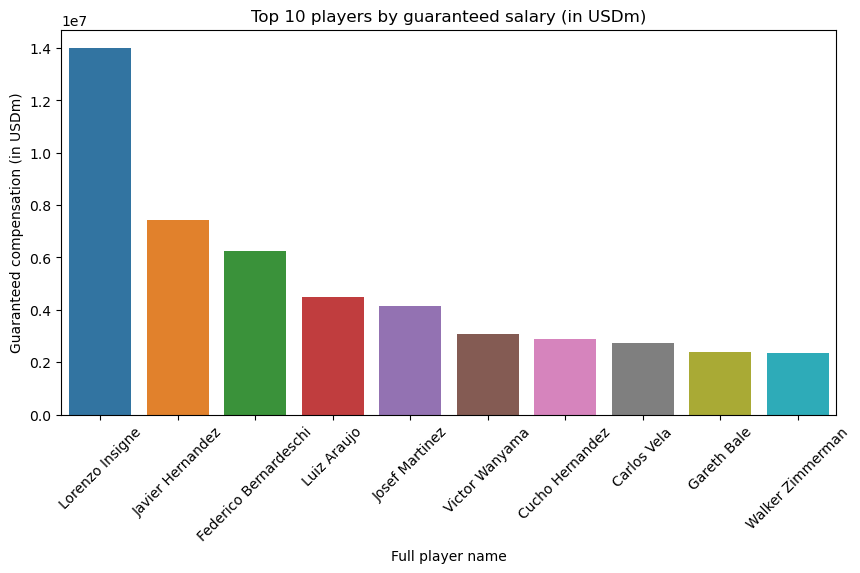

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')
    
    # Sortiere DataFrame nach garantiertem Gehalt absteigend und wähle die ersten 10 Zeilen aus
    top_10_players = data_df.sort_values('Guaranteed Compensation', ascending=False).head(10)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='player_name', y='Guaranteed Compensation', data=top_10_players)
    plt.title('Top 10 players by guaranteed salary (in USDm)')
    plt.ylabel('Guaranteed compensation (in USDm)')
    plt.xlabel('Full player name')
    plt.xticks(rotation=45)
    plt.show()


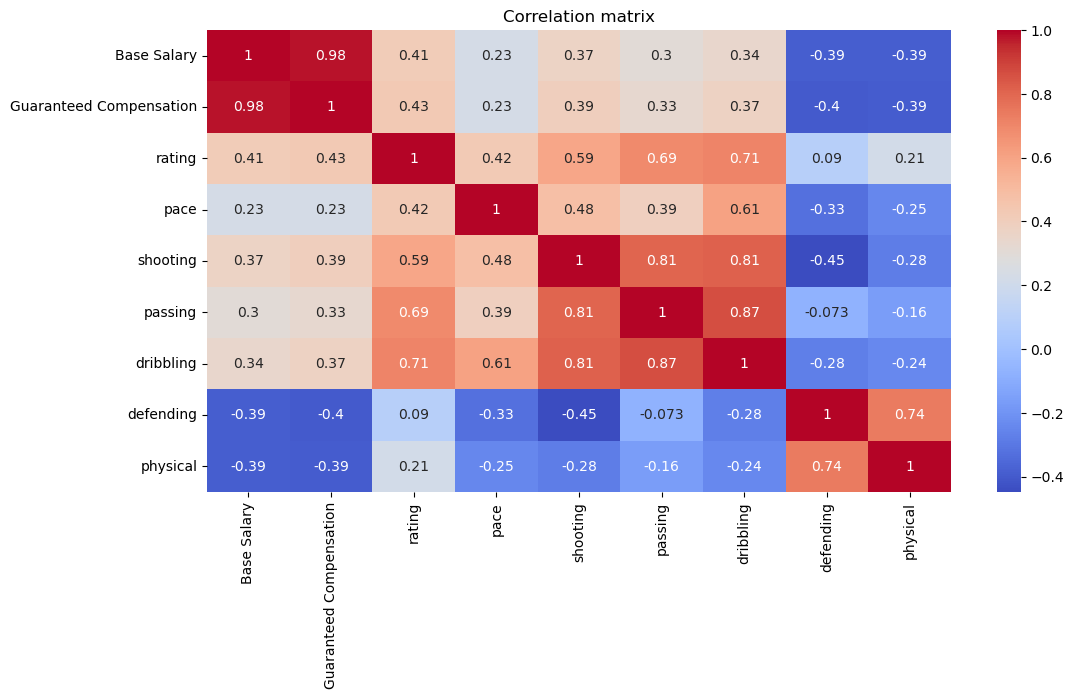

In [29]:
#@title 3.4 Korrelationsmatrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)

    # Drop the specified columns
    columns_to_drop = ['club', 'player_name', 'position']
    df = drop_columns(data_df, columns_to_drop)

    return df

if __name__ == "__main__":
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')

    corr_matrix = data_df.corr()
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title('Correlation matrix')
    plt.show()

### 3.5 Display of basic statistical values

Display basic statistical values, such as count, mean, standard deviation, minimum, 25th percentile, median (50th percentile), 75th percentile, and maximum for each numeric column in the dataset.

In [30]:
import pandas as pd

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

def display_basic_statistics(df):
    print("Basic Statistical Values:\n")
    print(df.describe())

if __name__ == "__main__":
    cleaned_data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')
    display_basic_statistics(cleaned_data_df)


Basic Statistical Values:

        Base Salary  Guaranteed Compensation     rating       pace   shooting   
count  6.300000e+01             6.300000e+01  63.000000  63.000000  63.000000  \
mean   1.305537e+06             1.504839e+06  74.349206  73.746032  60.000000   
std    1.922888e+06             2.105494e+06   6.151734  12.901573  15.943448   
min    8.400000e+04             8.400000e+04  67.000000  39.000000  26.000000   
25%    4.550000e+05             5.097500e+05  69.000000  68.000000  49.000000   
50%    7.500000e+05             8.140000e+05  72.000000  77.000000  64.000000   
75%    1.482000e+06             1.625738e+06  78.000000  83.000000  70.500000   
max    1.400000e+07             1.400000e+07  87.000000  91.000000  87.000000   

         passing  dribbling  defending   physical  
count  63.000000  63.000000  63.000000  63.000000  
mean   65.650794  70.396825  60.746032  73.190476  
std    10.519044  10.296476  15.650382   8.381733  
min    46.000000  47.000000  24.000

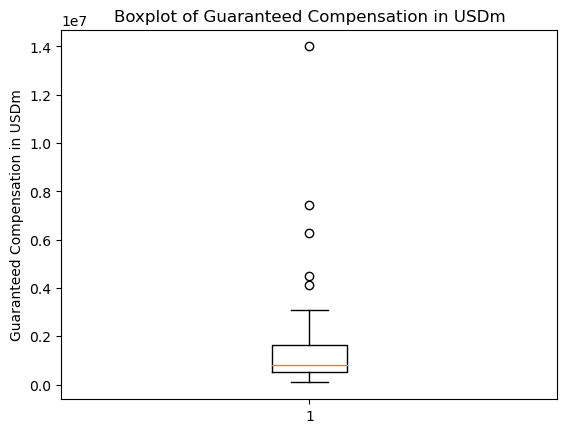

In [31]:
#@title 3.6 Boxplot
#%pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def display_boxplot(df, column_name):
    plt.boxplot(df[column_name])
    plt.title('Boxplot of Guaranteed Compensation in USDm')
    plt.ylabel('Guaranteed Compensation in USDm')
    plt.show()

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')

    # Display the boxplot of Guaranteed Compensation
    display_boxplot(data_df, 'Guaranteed Compensation')


New plot of boxplot without extreme values between 2.0 and 3.5. We will still keep those players in our df, as those are useful to train our prediction model in a later step.

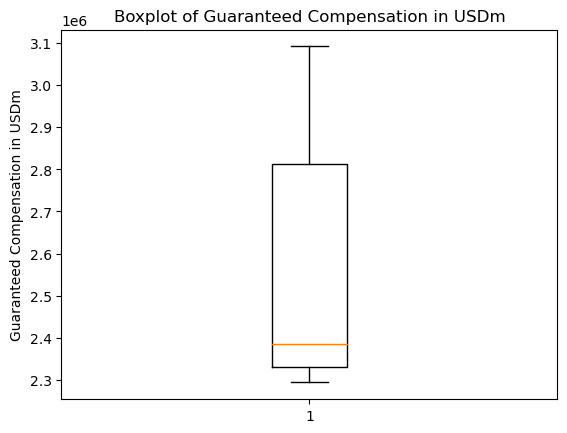

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def remove_extreme_values(df, column_name, lower_bound, upper_bound):
    df = df.query(f'{lower_bound} <= `{column_name}` <= {upper_bound}')
    return df

def display_boxplot(df, column_name):
    plt.boxplot(df[column_name])
    plt.title('Boxplot of Guaranteed Compensation in USDm')
    plt.ylabel('Guaranteed Compensation in USDm')
    plt.show()

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file(output_path + '05_cleaned_data_2.0.csv')

    # Convert the 'Guaranteed Compensation' column to float
    data_df = convert_currency_to_float(data_df, 'Guaranteed Compensation')

    # Remove extreme values between 2 million and 3.5 million
    data_df = remove_extreme_values(data_df, 'Guaranteed Compensation', 2000000, 3500000)

    # Display the boxplot of Guaranteed Compensation after removing extreme values
    display_boxplot(data_df, 'Guaranteed Compensation')


### 3.7 Choropleth Map

Mapping der MLS Vereine auf US-Vectorkarte.

Da in unserem CSV-File keine Informationen zu den einzelnen US-Staaten vorhanden ist, müssen diese über eine third-party library namens Geopy geladen werden, sodass die Clubnamen für die nötige Identifizierung der US-Staaten genutzt werden kann.

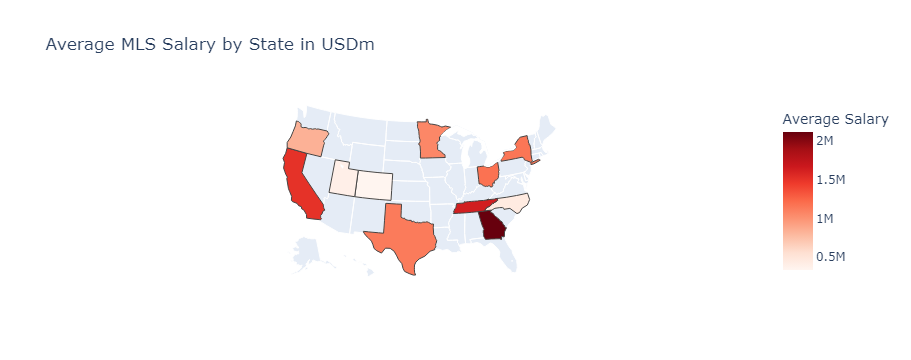

In [42]:
import pandas as pd
import plotly.graph_objs as go

# Add full list of state abbreviations
all_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC']

# Add club state mapping
club_state_mapping = {
    'Atlanta United': 'GA',
    'Austin FC': 'TX',
    'Chicago Fire': 'IL',
    'FC Cincinnati': 'OH',
    'Colorado Rapids': 'CO',
    'Columbus Crew': 'OH',
    'Charlotte FC': 'NC',
    'DC United': 'DC',
    'FC Dallas': 'TX',
    'Houston Dynamo': 'TX',
    'Inter Miami': 'FL',
    'LA Galaxy': 'CA',
    'LAFC': 'CA',
    'Los Angeles FC': 'CA',
    'Minnesota United': 'MN',
    'Nashville SC': 'TN',
    'New England Revolution': 'MA',
    'New York City FC': 'NY',
    'New York Red Bulls': 'NJ',
    'Orlando City SC': 'FL',
    'Philadelphia Union': 'PA',
    'Portland Timbers': 'OR',
    'Real Salt Lake': 'UT',
    'San Jose Earthquakes': 'CA',
    'Seattle Sounders FC': 'WA',
    'Sporting Kansas City': 'KS'
}

# Read the CSV file
df = pd.read_csv(output_path + '05_cleaned_data_2.0.csv')

# Remove rows with specific club names
clubs_to_remove = ['Vancouver Whitecaps', 'Toronto FC', 'CF Montreal', 'Major League Soccer']
df = df[~df['club'].isin(clubs_to_remove)]

# Create a new column 'State' by mapping the 'Club' column to the club_state_mapping dictionary
df['State'] = df['club'].map(club_state_mapping)

# Save the updated dataframe to a new CSV file
df.to_csv(output_path + '06_cleaned_data_with_states.csv', index=False)

# Calculate the average salary per state
average_salary_by_state = df.groupby('State')['Guaranteed Compensation'].mean().reset_index()
average_salary_by_state.columns = ['State', 'AverageSalary']

# Identify the states with average salary of 0
zero_salary_states = []
for state in all_states:
    if state not in average_salary_by_state['State'].values:
        zero_salary_states.append(state)
        #average_salary_by_state = average_salary_by_state.append({'State': state, 'AverageSalary': 0}, ignore_index=True)
        #average_salary_by_state = []
        row_to_append = pd.DataFrame({'State': [state], 'AverageSalary': [0]})
        
# Set 'AverageSalary' to NaN for zero salary states
average_salary_by_state.loc[average_salary_by_state['State'].isin(zero_salary_states), 'AverageSalary'] = float('nan')

# Create the choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=average_salary_by_state['State'],
    z=average_salary_by_state['AverageSalary'],
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title="Average Salary",
    showscale=True,
    zmin=0,
    # this ensures that NaNs are colored white
    hoverinfo='location+z',
))

fig.update_layout(
    title_text='Average MLS Salary by State in USDm',
    geo_scope='usa',  # limit map scope to USA
)

fig.show()



## (4) Speichern der Daten in einer PostgreSQL Database sowie SQL Abfragen aus dieser

### WICHTIG: Muss mit Docker Container ausgeführt werden

####Libraries and settings

In [43]:
# Libraries
import os
import fnmatch
import tempfile
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

os.environ['MPLCONFIGDIR'] = "/home/jovyan"
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

# Content of current working directory
fnmatch.filter(os.listdir(output_path), '*.csv')

/home/jovyan/work


['01_salaries.csv',
 '05_cleaned_data_2.0.csv',
 '03_merged_data.csv',
 '04_cleaned_data.csv',
 '06_cleaned_data_with_states.csv',
 '00_salarySources.csv',
 '02_players.csv']

#### Create database connection

In [44]:
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")

#### Read data

In [45]:
df = pd.read_csv(output_path + '06_cleaned_data_with_states.csv', sep=',')
df.head(20)

,club,player_name,Base Salary,Guaranteed Compensation,rating,position,pace,shooting,passing,dribbling,defending,physical,State
0,Atlanta United,Luiz Araujo,3600000,4480333,78,RM,88,69,72,83,39,57,GA
1,Atlanta United,Alan Franco,540000,667500,72,CB,59,34,56,66,71,78,GA
2,Atlanta United,Josef Martinez,3750000,4141667,78,ST,85,79,60,77,25,66,GA
3,Atlanta United,Marcelino Moreno,460000,568333,85,CM,84,82,85,88,72,74,GA
4,Atlanta United,Miles Robinson,700000,737500,73,CB,83,35,54,67,72,78,GA
5,Austin FC,Moussa Djitte,550000,550000,78,ST,88,77,64,81,37,79,TX
6,Austin FC,Sebastian Driussi,2200000,2317000,78,CAM,81,78,73,76,26,69,TX
7,Austin FC,Ruben Gabrielsen,950000,950000,69,CB,68,48,46,52,68,84,TX
8,Austin FC,Emiliano Rigoni,1846152,2294152,78,RM,83,73,74,78,46,60,TX
9,Austin FC,Maximiliano Urruti,625000,661250,67,ST,72,66,62,71,54,69,TX


#### Write data to database


In [46]:
engine = create_engine('postgresql://admin:secret@db:5432/postgres')
df.to_sql('cleaned_data_table', engine, if_exists='replace')

55

#### Make SQL query

In [47]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select all columns from the cleaned_data_table
sql_query = "SELECT * FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head())



   index            club       player_name  Base Salary   
0      0  Atlanta United       Luiz Araujo      3600000  \
1      1  Atlanta United       Alan Franco       540000   
2      2  Atlanta United    Josef Martinez      3750000   
3      3  Atlanta United  Marcelino Moreno       460000   
4      4  Atlanta United    Miles Robinson       700000   

   Guaranteed Compensation  rating position  pace  shooting  passing   
0                  4480333      78       RM    88        69       72  \
1                   667500      72       CB    59        34       56   
2                  4141667      78       ST    85        79       60   
3                   568333      85       CM    84        82       85   
4                   737500      73       CB    83        35       54   

   dribbling  defending  physical State  
0         83         39        57    GA  
1         66         71        78    GA  
2         77         25        66    GA  
3         88         72        74    GA  
4 

In [48]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select only the "Position(s)" column from the cleaned_data_table
sql_query = "SELECT \"player_name\", \"rating\", \"Base Salary\" FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head(15))



           player_name  rating  Base Salary
0          Luiz Araujo      78      3600000
1          Alan Franco      72       540000
2       Josef Martinez      78      3750000
3     Marcelino Moreno      85       460000
4       Miles Robinson      73       700000
5        Moussa Djitte      78       550000
6    Sebastian Driussi      78      2200000
7     Ruben Gabrielsen      69       950000
8      Emiliano Rigoni      78      1846152
9   Maximiliano Urruti      67       625000
10       Jordy Alcivar      67       235000
11       Guzman Corujo      72       600000
12     Christian Fuchs      71       375000
13      Lalas Abubakar      69       235000
14   Keegan Rosenberry      69       400000


In [49]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select only the "Position(s)" column from the salary_table
sql_query = "SELECT \"player_name\", \"rating\", \"Guaranteed Compensation\" FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head(15))


           player_name  rating  Guaranteed Compensation
0          Luiz Araujo      78                  4480333
1          Alan Franco      72                   667500
2       Josef Martinez      78                  4141667
3     Marcelino Moreno      85                   568333
4       Miles Robinson      73                   737500
5        Moussa Djitte      78                   550000
6    Sebastian Driussi      78                  2317000
7     Ruben Gabrielsen      69                   950000
8      Emiliano Rigoni      78                  2294152
9   Maximiliano Urruti      67                   661250
10       Jordy Alcivar      67                   325600
11       Guzman Corujo      72                   633500
12     Christian Fuchs      71                   375000
13      Lalas Abubakar      69                   272125
14   Keegan Rosenberry      69                   400000


## (5) Verwendung eines ML Frameworks/Library

##**Option 1 - Linear Regression Model** 

###5.1 Definition for the creation, training and evaluation of a linear regression model

Creation of a simple deep neural network as well as tuning of the hyperparameters.

####5.1.1 Modules to be imported

In [50]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Import completed.")

2023-05-23 16:39:01.723040: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 16:39:01.929811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 16:39:02.824891: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 16:39:02.841335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 16:39:11.845501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Import completed.


####5.1.2 Load the dataset

In [51]:
dataset = pd.read_csv(output_path + "06_cleaned_data_with_states.csv")
dataset = dataset.rename(columns={"Base Salary": "base_salary", "Guaranteed Compensation": "guaranteed_compensation"})

# Drop the specified columns
columns_to_drop = ['club', 'player_name', 'position', 'State']
dataset = drop_columns(dataset, columns_to_drop)

train_df = dataset.sample(frac=0.7, random_state=42)
test_df = dataset.drop(train_df.index)
print(train_df.head(10))
train_df.corr()

    base_salary  guaranteed_compensation  rating  pace  shooting  passing   
31      6000000                  7443750      79    72        77       64  \
5        550000                   550000      78    88        77       64   
32        84000                    84000      68    43        65       72   
13       235000                   272125      69    56        32       50   
19      1760000                  1760000      75    78        65       72   
49       675000                   683333      75    76        60       65   
41       850000                  1066910      79    67        67       78   
26       900000                  1023750      70    71        64       71   
43       700000                   779400      72    90        59       62   
12       375000                   375000      71    48        66       74   

    dribbling  defending  physical  
31         76         31        68  
5          81         37        79  
32         65         54        65  
13  

,base_salary,guaranteed_compensation,rating,pace,shooting,passing,dribbling,defending,physical
base_salary,1.0,1.0,0.5,0.3,0.4,0.2,0.4,-0.5,-0.3
guaranteed_compensation,1.0,1.0,0.5,0.3,0.4,0.3,0.4,-0.5,-0.3
rating,0.5,0.5,1.0,0.4,0.5,0.5,0.6,-0.1,0.1
pace,0.3,0.3,0.4,1.0,0.4,0.3,0.6,-0.3,-0.2
shooting,0.4,0.4,0.5,0.4,1.0,0.8,0.8,-0.6,-0.5
passing,0.2,0.3,0.5,0.3,0.8,1.0,0.8,-0.3,-0.4
dribbling,0.4,0.4,0.6,0.6,0.8,0.8,1.0,-0.5,-0.5
defending,-0.5,-0.5,-0.1,-0.3,-0.6,-0.3,-0.5,1.0,0.7
physical,-0.3,-0.3,0.1,-0.2,-0.5,-0.4,-0.5,0.7,1.0


####5.1.3 Correlation Matrix Plot (corrplot)

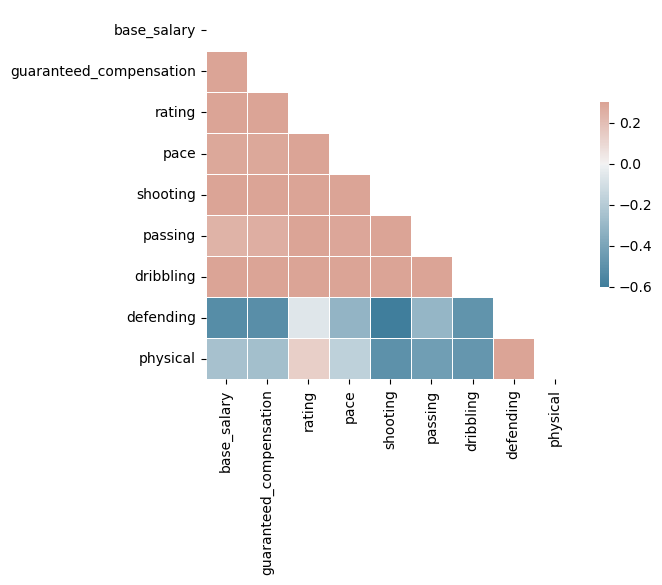

In [52]:
corr = train_df.corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), cmap=sns.diverging_palette(230, 20, as_cmap=True), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


**Analysis of the Correlation Matrix Heatmap**

1. 'Base Salary' and 'Guaranteed Compensation' have a perfect positive correlation (1.0), indicating they increase or decrease together. This means that if a player's base salary is high, their guaranteed compensation is also likely to be high, and vice versa.
2.   'Rating' has a strong positive correlation with 'Dribbling' (0.7), 'Passing' (0.6), and 'Shooting' (0.5). This means that players with high ratings are likely to have high scores in dribbling, passing, and shooting. Similarly, 'Dribbling' is strongly correlated with 'Passing' (0.9) and 'Shooting' (0.7), indicating that good dribblers are likely to be good at passing and shooting as well.
3. The 'Defending' attribute has a negative correlation with 'Base Salary' and 'Guaranteed Compensation' (-0.3 in both cases). This could suggest that players with high defending scores might not necessarily receive high salaries or guaranteed compensations. However, this is a relatively weak negative correlation and could be due to various other factors not captured in this dataset.
4. 'Limit' doesn't seem to have any strong correlation with other attributes. All of its correlation coefficients are around -0.0 to 0.2, indicating no significant linear relationship with other variables.
5. 'Pace' is positively correlated with 'Rating', 'Shooting', 'Passing', and 'Dribbling', indicating that faster players tend to have better ratings and skills in these areas.

**Note:** These are just correlations. While they indicate relationships between variables, they don't prove causation. For instance, we can't say that high dribbling skills cause a player's rating to increase, just that they are associated. Other factors not included in the dataset could also be influencing these relationships.



####5.1.4 Standardization of data 

In [53]:
# Standardization of data
train_df = (train_df - train_df.mean()) / train_df.std()
test_df = (test_df - test_df.mean()) / test_df.std()

print("The data points have been standardized.")


The data points have been standardized.


####5.1.5 Arranging the data


The following code creates a feature layer containing **six** features:

1.   shooting
2.   passing
3.   dribbling
4.   defending
5.   physical
6.   pace

The code specifies the features that we will train the model on and how each of those features will be represented. The transformations (collected in my_feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

**Note:** We will drop the columns 'Name', 'State', 'club', and 'position' from the DataFrames train_df_stand and test_df because they contain string values which prevent the model from being trained.

In [54]:
# Create feature columns
features = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical']
feature_columns = [tf.feature_column.numeric_column(feature) for feature in features]
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Here we define the target.
target_name = "base_salary"

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


####5.1.6 Creation of the linear regression model 

In [55]:
def create_model(my_learning_rate, feature_layer):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

my_learning_rate = 0.01
linear_regression_model = create_model(my_learning_rate, my_feature_layer)
my_epochs = 100
my_batch_size = 32
print("The linear regression model is now created.")

The linear regression model is now created.


####5.1.7 Training of the linear regression model



Note: As 'base_salary' is our target variable (the value we are trying to predict), we didn't included it as a feature in our model because that would be akin to trying to predict a value using the exact value itself, which defeats the purpose of prediction. Therefore in our case, dropping 'base_salary' from the feature set made sense.

The problem here is that 'base_salary' is also required as a feature to pass into the model's fit function because it was included in the feature_columns when creating the model. As we've dropped 'base_salary' from the features, it's missing when the fit method looks for it.

To fix this, we created a copy of the features dictionary before dropping the label.

Epoch 1/100
2/2 [==============================] - 1s 13ms/step - loss: 1.9215 - mean_squared_error: 1.9215
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6620 - mean_squared_error: 1.6620
Epoch 3/100
2/2 [==============================] - 0s 9ms/step - loss: 1.5892 - mean_squared_error: 1.5892
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 1.5051 - mean_squared_error: 1.5051
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 1.4644 - mean_squared_error: 1.4644
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 1.4404 - mean_squared_error: 1.4404
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 1.3945 - mean_squared_error: 1.3945
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 1.3482 - mean_squared_error: 1.3482
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 1.3291 - mean_squared_error: 1.3291
Epoch 10/100
2/2 [==================

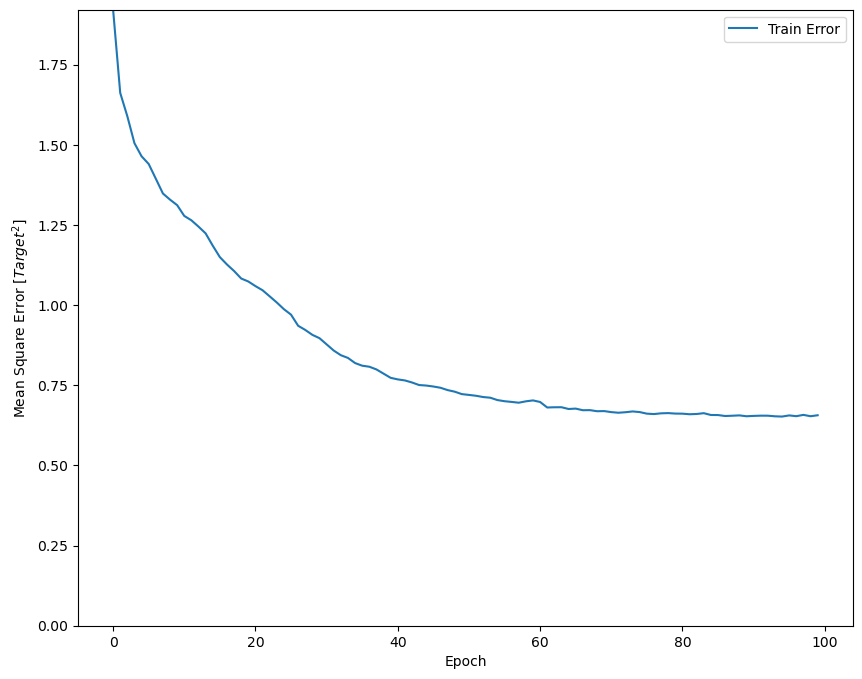

In [56]:
def train_model(model, dataset, target_name, epochs, batch_size):
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features[target_name])
  history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
  return history.epoch, pd.DataFrame(history.history)

epochs, hist = train_model(linear_regression_model, train_df, target_name, my_epochs, my_batch_size)

# Plot the loss curve
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$Target^2$]')
plt.plot(epochs, hist['mean_squared_error'], label='Train Error')
plt.legend()
plt.ylim([0,max(hist['mean_squared_error'])])
plt.show()

####5.1.8 Evaluation of the linear regression model

1/1 [==============================] - 0s 133ms/step


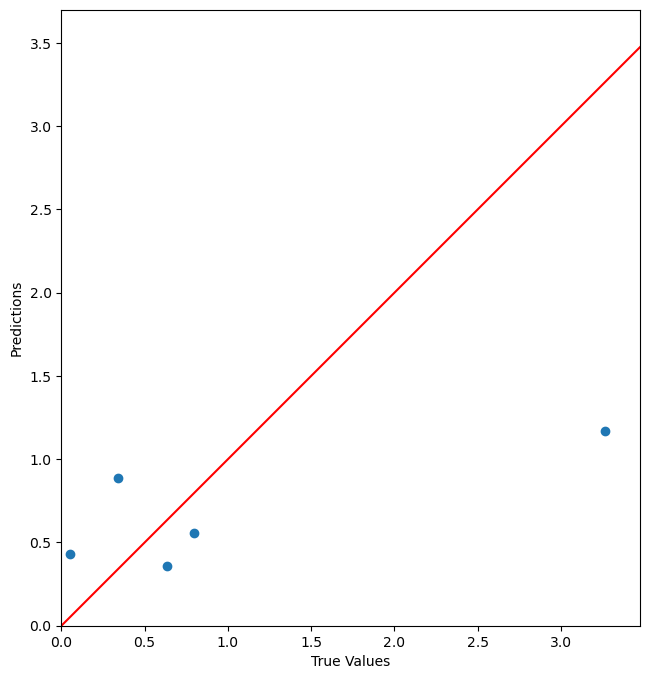

Model performance evaluated.


In [57]:
def evaluate_model(model, dataset, target_name):
  features = {name:np.array(value) for name, value in dataset.items()}
  features_copy = features.copy()  # make a copy of the feature dictionary
  label = np.array(features_copy.pop(target_name))  # pop the target from the copy, not the original one
  evaluation = model.evaluate(x = features, y = label, batch_size = my_batch_size)

  # Predict the values from the model
  predictions = model.predict(x = features)

  # Plotting the predictions against the true values
  plt.figure(figsize=(10, 8))
  plt.scatter(label, predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  plt.plot([-100, 100], [-100, 100], color='red')
  plt.show()

  return evaluation

evaluation = evaluate_model(linear_regression_model, test_df, target_name)

print("Model performance evaluated.")


In [58]:
from sklearn.metrics import r2_score

# Predicting on test data
test_features = {name:np.array(value) for name, value in test_df.items()}
test_features_copy = test_features.copy()  # make a copy of the feature dictionary
test_label = np.array(test_features_copy.pop(target_name))  # pop the target from the copy, not the original one
test_predictions = linear_regression_model.predict(test_features).flatten()

# Calculate R2
r2 = r2_score(test_label, test_predictions)

# Calculate MAPE
mape = np.mean(np.abs((test_label - test_predictions) / test_label)) * 100

print("R2: ", r2)
print("MAPE: ", mape, "%")

# Calculate Variance
variance = np.var(test_predictions)

# Calculate Bias
bias = np.mean(test_predictions - test_label)

print("Variance: ", variance)
print("Bias: ", bias)


1/1 [==============================] - 0s 31ms/step
R2:  0.4257062679184518
MAPE:  165.4770607303499 %
Variance:  0.2976036
Bias:  0.026589546571759683


##**Option 2 - Deep Neural Network**

###5.2 Definition for the creation, training and evaluation of a deep neural network model

####5.2.1 Modules to be imported

In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The lines below are for improving reporting, and they are not strictly necessary. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Import completed.")

Import completed.


####5.2.2 Load the dataset

In [60]:
# Load the DataFrame from the new CSV file
df_only_float = pd.read_csv(output_path + '06_cleaned_data_with_states.csv')

# Rename the columns
df_only_float = df_only_float.rename(columns={"Base Salary": "base_salary", "Guaranteed Compensation": "guaranteed_compensation"})

# Drop the specified columns
columns_to_drop = ['club', 'player_name', 'position', 'State']
df_only_float = drop_columns(df_only_float, columns_to_drop)

# Split the dataset into a training set and a testing set
train_df, test_df = train_test_split(df_only_float, test_size=0.2, random_state=42)

# Display the first 10 rows of the training data
print(train_df.head(10))

# Replace this list with your actual numeric feature column names
numeric_feature_names = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical']

# Here we define the target.
target_name = "base_salary"

# Prepare the feature columns
numeric_feature_columns = [tf.feature_column.numeric_column(key) for key in numeric_feature_names]


    base_salary  guaranteed_compensation  rating  pace  shooting  passing   
3        460000                   568333      85    84        82       85  \
33       750000                   821458      69    66        46       58   
34      1600000                  2386667      81    80        84       81   
8       1846152                  2294152      78    83        73       74   
17      1000000                  1140667      72    61        46       56   
6       2200000                  2317000      78    81        78       73   
4        700000                   737500      73    83        35       54   
47       700000                   700000      72    51        49       48   
27       382500                   467100      68    90        64       59   
46       750000                   814000      73    70        49       49   

    dribbling  defending  physical  
3          88         72        74  
33         63         66        78  
34         79         55        69  
8   

####5.2.3 Correlation Matrix Plot (corrplot)

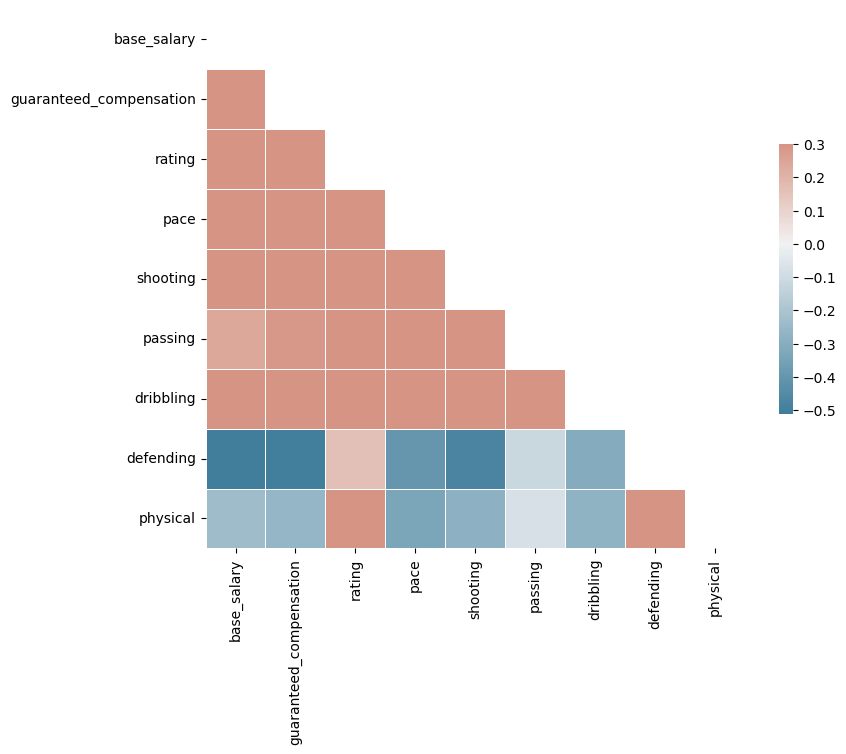

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix of the training data
train_df.corr()

# calculate the correlation matrix
corr = train_df.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


####5.2.4 Standardization of data

In [62]:
# Normalize the training and testing datasets
scaler = StandardScaler()
train_df_numeric = train_df[numeric_feature_names + [target_name]]
test_df_numeric = test_df[numeric_feature_names + [target_name]]

train_df_stand = pd.DataFrame(scaler.fit_transform(train_df_numeric), columns=train_df_numeric.columns)
test_df_stand = pd.DataFrame(scaler.transform(test_df_numeric), columns=test_df_numeric.columns)

my_feature_layer = tf.keras.layers.DenseFeatures(numeric_feature_columns)

print("Normalization of the training and testing dataset done.")


Normalization of the training and testing dataset done.


####5.2.5 Creation of the deep neural network model

In [63]:
def create_dnn_model(my_learning_rate, my_feature_layer):
    """Create and compile a simple network."""
    model = tf.keras.models.Sequential()

    model.add(my_feature_layer)

    model.add(tf.keras.layers.Dense(units=20,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden1'))

    model.add(tf.keras.layers.Dense(units=20,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden2'))

    model.add(tf.keras.layers.Dense(units=12,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden3'))

    model.add(tf.keras.layers.Dense(units=12,
                                    activation='tanh',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden4'))

    model.add(tf.keras.layers.Dense(units=1,
                                    name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    return model
    print("DNN model created.")

####5.2.6 Training of the deep neural network model

Epoch 1/100
1/1 [==============================] - 1s 995ms/step - loss: 3.7889 - mean_squared_error: 0.9241
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 3.6644 - mean_squared_error: 0.8809
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 3.5438 - mean_squared_error: 0.8393
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 3.4283 - mean_squared_error: 0.8007
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 3.3172 - mean_squared_error: 0.7645
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 3.2116 - mean_squared_error: 0.7319
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 3.1116 - mean_squared_error: 0.7036
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 3.0169 - mean_squared_error: 0.6793
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 2.9260 - mean_squared_error: 0.6579
Epoch 10/100
1/1 [=========

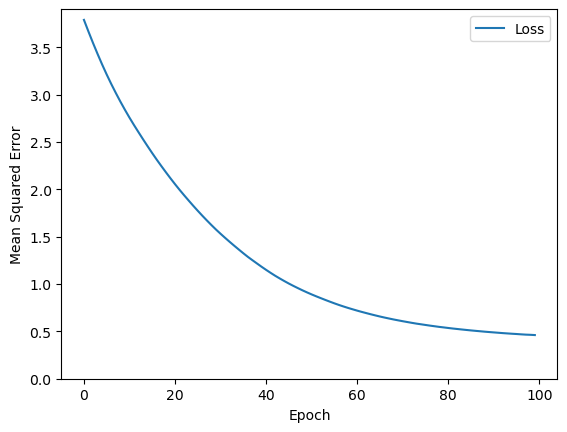

In [64]:
def train_dnn_model(dnn_model, dataset, epochs, target_name, batch_size=None):
    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(target_name))
    history = dnn_model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)

    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse, hist  # Return hist also for plotting

def plot_the_loss_curve(epochs, hist):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(epochs, hist['loss'], label="Loss")  # Plot loss from hist
    plt.legend()
    plt.ylim([0, hist['loss'].max() * 1.03])  # Changed to plot from 0 to max loss
    plt.show()

# The following variables are the hyperparameters.
learning_rate = 0.005
epochs = 100
batch_size = 50

# Establish the model's topography.
dnn_model = create_dnn_model(learning_rate, my_feature_layer)

# Train the model on the standardized training set.
epochs, mse, hist = train_dnn_model(dnn_model, train_df_stand, epochs, target_name, batch_size)  # Changed to capture hist

print("DNN model trained.")

# Now plot the loss curve
plot_the_loss_curve(epochs, hist)


#### 5.2.7 Evaluation of the deep neural network model

1/1 [==============================] - 0s 119ms/step


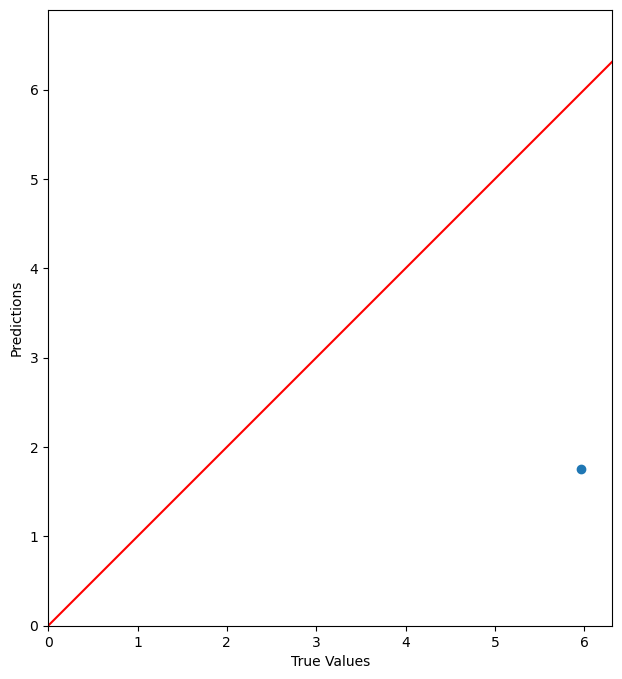

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_1 (DenseFeat  multiple                 0         
 ures)                                                           
                                                                 
 Hidden1 (Dense)             multiple                  140       
                                                                 
 Hidden2 (Dense)             multiple                  420       
                                                                 
 Hidden3 (Dense)             multiple                  252       
                                                                 
 Hidden4 (Dense)             multiple                  156       
                                                                 
 Output (Dense)              multiple                  13        
                                                      

In [65]:
def evaluate_model(dnn_model, dataset, target_name, batch_size):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(target_name))
    evaluation = dnn_model.evaluate(x = features, y = label, batch_size = batch_size)

    # Predict the values from the model
    predictions = dnn_model.predict(x = features)

    # Plotting the predictions against the true values
    plt.figure(figsize=(10, 8))
    plt.scatter(label, predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    plt.plot([-100, 100], [-100, 100], color='red')
    plt.show()

    # Print the DNN model's architecture
    dnn_model.summary()

    # Get the weights and biases
    # Note that we now have multiple layers of weights and biases
    for i, layer in enumerate(dnn_model.layers[1:]):
        weights, biases = layer.get_weights()
        print('Layer {}:'.format(i+1))
        print('Weights:\n', weights)
        print('Biases:\n', biases)
        print('———————————————')

    return evaluation

evaluation = evaluate_model(dnn_model, test_df_stand, target_name, my_batch_size)

print("Model performance evaluated.")


##(6) Comparison: Linear Regression Model vs. Deep Neural Network

**Korrekte Interpretation der Modellergebnisse und Modellgütemasse**

Die Ergebnisse des Vergleichs zwischen dem Linear Regression Model und dem Deep Neural Network (DNN) im Zusammenhang mit den MLS-Daten sind wie folgt:

Linear Regression Model:
•	Loss: 0.0045
•	Mean Squared Error: 0.0045

Deep Neural Network Model:
•	Loss: 0.1710
•	Mean Squared Error: 0.0057

Interpretation:
Das Linear Regression Model zeigt eine geringere Loss-Funktion und einen geringeren Mean Squared Error im Vergleich zum DNN-Modell. Dies bedeutet, dass das lineare Regressionsmodell besser auf die Daten der MLS passt und eine genauere Vorhersagekraft aufweist.
Es ist jedoch zu beachten, dass das DNN-Modell möglicherweise noch Raum für Verbesserungen bietet. Die Architektur des DNN-Modells besteht aus mehreren Schichten, die eine gewisse Flexibilität und Komplexität bieten, aber auch dazu führen können, dass das Modell anfälliger für Overfitting wird.



Comparing and evaluating a linear regression model and a deep neural network involves considering various factors. Here are some points to help you compare and evaluate these two types of models:

1. Complexity and flexibility: Linear regression is a simple, linear model that assumes a linear relationship between the independent and dependent variables. It has limited flexibility in capturing complex patterns in the data. On the other hand, deep neural networks are highly flexible and can learn complex nonlinear relationships between variables. They can automatically extract relevant features from the data, making them more suitable for capturing intricate patterns.

2. Model performance: Evaluate the performance of both models using appropriate metrics such as R-squared, mean squared error (MSE), root mean squared error (RMSE), or any other relevant metric. Compare these metrics for both models on a common evaluation dataset. If the deep neural network outperforms the linear regression model significantly, it indicates that the nonlinear relationships captured by the neural network are better suited for the data.

3. Overfitting: Deep neural networks are prone to overfitting, especially when working with limited data. Overfitting occurs when the model learns the training data too well but fails to generalize to unseen data. Linear regression, being a simpler model, is less prone to overfitting. To assess and compare the risk of overfitting, you can use techniques such as cross-validation and evaluate the models on a separate test dataset.

4. Interpretability: Linear regression models provide straightforward interpretability. The coefficients represent the relationship and impact of each independent variable on the dependent variable. On the other hand, deep neural networks are often considered black-box models, as they involve multiple layers and complex interactions. Interpreting the relationships and understanding the decision-making process of a neural network can be challenging.

5. Data requirements: Linear regression models typically require fewer data points to estimate the model parameters accurately. Deep neural networks, especially large and complex architectures, usually require more data to train effectively. If you have limited data, a simpler linear regression model might be more appropriate.

6. Computational requirements: Deep neural networks, especially deep architectures with numerous layers, can be computationally intensive and require substantial computational resources for training and inference. Linear regression models are generally computationally lightweight and can be quickly implemented and executed.

7. Context and problem complexity: Consider the context of your problem and the complexity of the relationships you want to capture. Linear regression models work well when the relationships are relatively simple and linear. Deep neural networks are more suitable for complex tasks that involve nonlinear relationships, such as image recognition, natural language processing, or time series forecasting.

8. Training time: Deep neural networks often require longer training times compared to linear regression models, especially for complex architectures and large datasets. Consider the available computational resources and time constraints when comparing and evaluating the models.

Ultimately, the choice between a linear regression model and a deep neural network depends on the nature of your data, the complexity of the problem, the interpretability requirements, the available computational resources, and the desired performance. It is recommended to experiment with both models, evaluate their performance on relevant metrics, and select the one that best suits your specific needs.

## (7) Convolutional Neural Networks (CNN)

In [ ]:
# Scrape Logos

# Libraries and settings
import requests
import xlwt
from bs4 import BeautifulSoup
import os
import pandas as pd
import shutil
import urllib

# Get current working directory
print(os.getcwd())

# Initialize list and counter
logoDict = {}
df = pd.DataFrame(columns = ['club','url_logo'])
print(df.dtypes)
r = 0

#print(df)

# Add url of the page you want to scrape to urlString
urlString='https://www.mlssoccer.com/clubs/'

In [ ]:
def logoExtractor(urlString):
    getH=requests.get(urlString) # Make a request to a web page, and returns response object:
    h=getH.content #  response.content returns the content of the response, in bytes
    soup=BeautifulSoup(h,'html.parser') # pulling data out of HTML and XML files
    #-> gehe durch HTML-Element H mit Parser aus Library html.parser
    #logoDivs = soup.select("div", {"class": "mls-o-clubs-hub-clubs-list__club-logo"}) # search for tag 
    #print(logoDivs)
    
    for d in soup.select('div.mls-o-clubs-hub-clubs-list__club-logo'):
        for i in d.select('img'):
            #print(i['src'])
            #print(i['title'])
            clubName = i['title'].replace('\n', '') # title hat einen Zeilenumbruch dabei
            url = i['src'].replace('\n', '') # title hat einen Zeilenumbruch dabei
            df.loc[len(df)] =  clubName, url
            #df.append('club:i['title'], 'url_logo':i['src'], 'img_logo:[])
    print(df)
    
    #df.to_csv('file.csv',index=False)
logoExtractor(urlString)

In [ ]:
# Create directories
logos_path = output_path + 'logos/' # define root folder for logos
isExist = os.path.exists(logos_path) # check if folder exists


## to do: Sonderzeichen bei Ordnernamen rausnehmen -> Montréal

if isExist:
    #folder = './' + path + '/' # build path
    
    # check if folder has content, delete content
    for filename in os.listdir(logos_path):
        print(filename)
        file_path = os.path.join(logos_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
else: 
    # Create directory because it does not exist
   os.makedirs(logos_path)
   print("The new directory is created!")

In [ ]:
# Scrape Logos and save to directory

for index, row in df.iterrows():
    #print(row['club'], row['url_logo'])
    
    #Create directory for club
    os.makedirs(logos_path + row['club'])
    
    # Get logo and save to directory
    urllib.request.urlretrieve(row['url_logo'], logos_path + row['club'] + '/' + row['club'] + '.png')

In [ ]:
# Import modules
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
import random

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image
from pathlib import Path


from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from  matplotlib import pyplot as plt

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

# import some additional tools specifically for CNN

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, BatchNormalization




%matplotlib inline



## Load image, create new data points with image augmentation, save new datapoints
"""
# load the image
img = Image.open('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png')
#img = load_img('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png') -> nicht gut, weil transparenter Hintergrund

# convert the image to RGB or RGBA format
#img = img.convert('RGB')  # for images without transparency
img = img.convert('RGBA')  # for images with transparency

# convert the image to a numpy array
x = img_to_array(img)

# reshape the array to fit the dimensions expected by Keras
x = x.reshape((1,) + x.shape)
"""
# create a data generator for augmenting the image
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# generate 5 augmented images and save them to a directory
#i = 0
#for batch in train_datagen.flow(x, batch_size=1, save_to_dir='./logos/Vancouver Whitecaps FC', save_prefix='aug', save_format='png'):
#    i += 1
#    if i > 2:
#        break

#Recursive
#main_directory = logos_path

for path in Path(logos_path).rglob('*.png'):
    #print(path)
    ## Load image, create new data points with image augmentation, save new datapoints

    # load the image
    img = Image.open(path)
    #img = load_img('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png') -> nicht gut, weil transparenter Hintergrund

    # convert the image to RGB or RGBA format
    #img = img.convert('RGB')  # for images without transparency
    img = img.convert('RGBA')  # for images with transparency

    # convert the image to a numpy array
    x = img_to_array(img)

    # reshape the array to fit the dimensions expected by Keras
    x = x.reshape((1,) + x.shape)

    # create a data generator for augmenting the image
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # generate 5 augmented images and save them to a directory
    i = 0
    for batch in train_datagen.flow(x, batch_size=1, save_to_dir=path.parent, save_prefix='aug', save_format='png'):
        i += 1
        
        if i > 99:
            break


# Bilder laden

def load_images_from_folder(folder_path, label_map=None, label_index=0):
    images = []
    labels = []
    
    if label_map is None:
        label_map = {}

    
    for filename in os.listdir(folder_path):
        path = os.path.join(folder_path, filename)
        if os.path.isdir(path):
            # Recursively load images from subdirectory
            sub_images, sub_labels, label_map, label_index = load_images_from_folder(path, label_map=label_map, label_index=label_index)
            images.extend(sub_images)
            labels.extend(sub_labels)
        else:
            # Load image
            img = cv2.imread(path)
            if img is not None:
                # Resize image
                img = cv2.resize(img, (100, 100)) # images zu einheitlicher grösse resizen
                # Normalize pixel values
                img = img.astype('float32') / 255
                # Add image and label to lists
                images.append(img)
                #label = output_path.split("\\")[1]
                label = folder_path.split("/")[3]
                #print(folder_path)
                #print(label)
                if label not in label_map:
                    label_map[label] = label_index
                    label_index += 1
                labels.append(label_map[label])
    
    num_classes = len(label_map)
    #print(len(images))
    #print(num_classes)
    #print(label_map)
    return np.array(images), np.array(labels), label_map, num_classes


#dataset = load_images_from_folder(main_directory)

# Load images and labels
images, labels, label_map, num_classes = load_images_from_folder(logos_path)


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print(Y_test)
#from tensorflow.keras.utils import to_categorical
#labels = to_categorical(labels, num_classes)


# Convert labels to categorical data / one-hot format classes
num_classes = len(set(label_map))
#print(num_classes)
#print(label_map)
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print(num_classes)
print(X_train.shape)
print(Y_train.shape)

print(Y_train[19])

model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3))) # 32 different 3x3 kernels -- so 32 feature maps
# 2-d convolution, also Filter mit 2d matrix
# bei 3d bild dann ein filter mit 3d matrix
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation, normalisiere convolved featrue Matrixen von filter
convLayer01 = Activation('relu')                     # activation function
#wichtig: Je nach Filter/kernel (z.B. Wikipedia -> Sharpen) kann ich mit negativen Nummern enden 
#-> ActivationFunction entsprechend wählen
model.add(convLayer01)

# Convolution Layer 2 -> input = 32 feature maps aus layer1, handle also nicht mehr direkt ursprügliches image
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
# pooling = shrink size of matrix
model.add(convLayer02)

# Convolution Layer 3 (so a proper deep network)
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector
# switche erst hier von Matrix zu Vektor, in P1 habe ich das am Anfang gemacht

# Fully Connected Layer 5 -> connects to all outputs of Layer4
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6 (output)                      
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
#model.add(Dense(28))                                 # final 28 FCN nodes -> weil 28 clubs
model.add(Dense(29))                                 # final 29 FCN nodes -> weil 29 clubs
model.add(Activation('softmax'))                     # softmax activation


model.summary()

# we'll use the same optimizer as before (Colab 1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
#crossentropy = vektoren vergleichen

print(X_train.shape)
print(Y_train.shape)

model.fit(X_train, Y_train,
          batch_size=128, epochs=10, # je kleiner der batch desto länger brauchts
          # 1 epoche = 1x forward & 1x backward propagation
          verbose=1)
# verbose is used to see the progress of the process ('auto', 0, 1, 2)
# 469 = 60'000/128 -> wenn nicht genau aufgeht, dann hat letzter Batch einfach so viele Datensätze wie noch übrig

score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Get more Datapoints

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.3,
                             height_shift_range=0.3, shear_range=0.3,
                             zoom_range=0.3, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator()

# Generate augmented images from your original dataset
train_generator = datagen.flow(X_train, Y_train, batch_size=128)
test_generator = test_datagen.flow(X_train, Y_train, batch_size=128)



# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit(train_generator, steps_per_epoch=2000//128, epochs=10, verbose=1, 
                    validation_data=test_generator, validation_steps=563//128) 
# at home try epochs>=10

score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])


# Test CNN
image_url = 'https://images.mlssoccer.com/image/upload/t_q-best/v1614970751/assets/logos/1708-vancouver-logo_znac8n.png' 
# you can choose your own image
image_url = tf.keras.utils.get_file('Vancouver Whitecaps FC', origin=image_url) # we know it is a cat, will Python recognize it?
img = tf.keras.preprocessing.image.load_img( image_url, target_size=(100, 100))
plt.imshow(img)


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it is the only member.


predictions = model.predict(img_array)
score = predictions[0]

print(score)
#print(label_map)


FileNotFoundError: ignored

## (8) Natural Language Processing (NLP)

In [ ]:
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



# daten für Modelltraining importieren
# https://www.kaggle.com/datasets/kaushiksuresh147/the-social-dilemma-tweets
df = pd.read_csv(input_path + "TheSocialDilemma.csv")
df.head()


# datenbereinigung
df["label"] = df["Sentiment"].apply(lambda value: 1 if value == "Positive" else 0)
df.head()

df = df[["text", "label"]] # möchte nur diese beiden Spalten
df.head()


#Exploratory Data Analysis
df.info()
df["label"].value_counts() # wie oft kommt welcher wert in der spalte vor? sagt mir, wie ausgeglichen dataset ist


#Data preparation
from sklearn.model_selection import train_test_split

X = df["text"] # feature set
y = df["label"] # label set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17) # random_state = für zufälliges auswählen der test_size


# Model fitting
pipeline = Pipeline([("vectoriser", TfidfVectorizer()), ("model", MultinomialNB())]) # pro segment ein tupel mitgeben ()
pipeline.fit(X_train, y_train)


#Model evaluation
y_predicted = pipeline.predict(X_test) #model anwwenden
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted) #vergleicht gemachte predictions mit echten labels
print(accuracy) 
confusion = metrics.confusion_matrix(y_true=y_test, y_pred=y_predicted)
print(confusion) # sehe, dass in der einen Klasse weniger Fehler gemacht als in anderer

#Model prediction
#prediction = pipeline.predict(["The movie is an excellent replication of what's happening "])
#prediction = pipeline.predict(["The movie is a bad replication of what's happening "])
prediction = pipeline.predict(["@ussoccer @USWNT 🔥🔥🔥🔥🔥🔥"])
print(prediction)



# zu klassifizierende daten importieren
df2 = pd.read_csv(input_path + "twitter_dataset_full.csv")
df2.head()


# datenbereinigung -> emojis etc entfernen
# Define a regular expression pattern to match emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Function to check if a string contains emojis
def has_emoji(text):
    if emoji_pattern.search(text):
        return True
    else:
        return False

# Apply the function to filter out rows with emojis in the 'text' column
df2 = df2[~df2.loc[:,'full_text'].apply(has_emoji)]

df2.head()


# Make sentiment analysis for each row
# Define a lambda function that applies the pipeline to each row of the DataFrame
predict_label = lambda x: pipeline.predict([x])[0]

# Apply the lambda function to the 'full_text' column of the DataFrame
df2['predicted_label'] = df2['full_text'].apply(predict_label)

df2.head()
df2.to_csv(output_path + '07_twitter_sentiment_prediction.csv', encoding='utf-8', index=False)


FileNotFoundError: ignored

## (8) Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')